This notebook analyzes the activity of freezing cells (those active during or before/after freezing epochs) across days and in response to ANI administration

In [3]:
# Import useful modules
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats
import matplotlib.gridspec as gridspec

In [1]:
# Import project specific modules and enable automatic reloading
import sys
from pathlib import Path
import os
eraser_path = Path(os.getcwd()).parent
reinstatement_path = eraser_path.parent / 'FearReinstatement'
sys.path.append(str(eraser_path))
sys.path.append(str(reinstatement_path))
%load_ext autoreload
%autoreload 2

from session_directory import find_eraser_directory as get_dir
import er_plot_functions as erp
import Placefields as pf
import freezing_analysis as fa
import helpers 

For starters, look at one mouse and map velocity over calcium activity.

In [3]:
# Load in neural data and freezing data
mouse, arena, day = 'Marble07', 'Shock', -2
dir_use = erp.get_dir(mouse, arena, day)
PF = pf.load_pf(mouse, arena, day)

video_t = erp.get_timestamps(str(dir_use))
freezing, velocity = erp.detect_freezing(str(dir_use), arena=arena)
video_t = video_t[:-1]  # Chop off last timepoint to make this the same length as freezing and velocity arrays

# Now get time for imaging
t_imaging = np.arange(0, PF.PSAbool_align.shape[1])/PF.sr_image

/Users/nkinsky/Documents/BU/Working/Eraser/Control Group/Marble7/20180319_2_fcbox: nbadpts = 2 max_in_a_row = 1


Visualization: plot neral activity with velocity and freezing overlaid

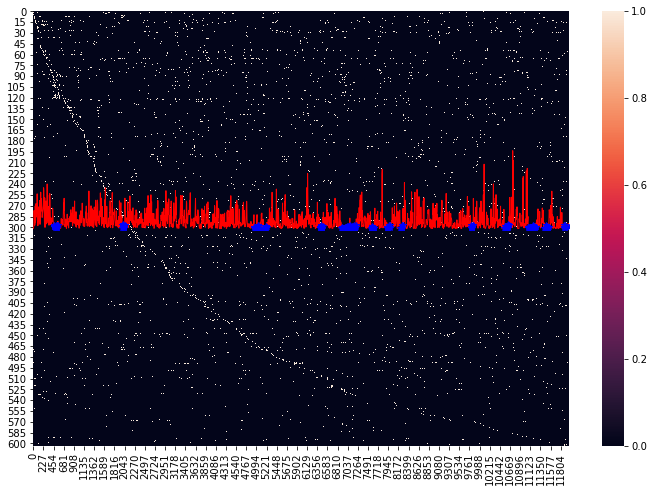

In [4]:
%matplotlib inline
SFvel = 4  # Factor to scale velocity by for overlay below

fig, ax = plt.subplots()
fig.set_size_inches([12,8])
sns.heatmap(data=PF.PSAbool_align, ax=ax)
nneurons = PF.PSAbool_align.shape[0]
ax.plot(video_t*PF.sr_image, velocity*-SFvel+nneurons/2, color='r', linewidth=1)
ax.plot(video_t[freezing]*PF.sr_image, velocity[freezing]*-SFvel+nneurons/2, 'b*')

Ok, now figure color the above calcium events by their event-rate during freezing and/or sort by event rate during freezing...

In [5]:
# This is now the function freezing_analysis.align_freezing_to_PSA.

# First, align freezing epochs to neural data 
nneurons, nframes = PF.PSAbool_align.shape

# convert freezing indices to timestamps
freezing_epochs = erp.get_freezing_epochs(freezing)
freezing_times = [[video_t[epoch[0]], video_t[epoch[1]]] for epoch in freezing_epochs]

# Make boolean to match neural data shape
freezingPSA = np.zeros(nframes, dtype='bool')
PSAtime = np.arange(0, nframes)/PF.sr_image
for freeze_time in freezing_times:
    freezingPSA[np.bitwise_and(PSAtime >= freeze_time[0], PSAtime < freeze_time[1])] = True

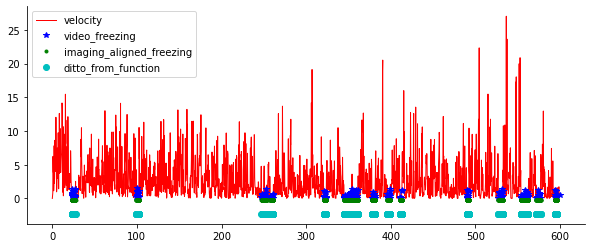

In [6]:
# Now double check that this matches the video freezing - it does!!!
%matplotlib inline
fig, ax = plt.subplots()
fig.set_size_inches(10,4)

# Plot freezing and velocity based on video reference frame
ax.plot(video_t, velocity, color='r', linewidth=1)
ax.plot(video_t[freezing], velocity[freezing], 'b*')

# Now plot based on imaging time-stamps
freezingPSA2 = fa.align_freezing_to_PSA(PF.PSAbool_align, PF.sr_image, freezing, video_t)
ax.plot(PSAtime[freezingPSA], (velocity.mean()-3)*np.ones_like(freezingPSA)[freezingPSA], 'g.')
ax.plot(PSAtime[freezingPSA2], (velocity.mean()-5)*np.ones_like(freezingPSA2)[freezingPSA2], 'co')

plt.legend(['velocity', 'video_freezing', 'imaging_aligned_freezing', 'ditto_from_function'])
sns.despine()

Now the interesting part - using this to calculate event rates during freezing!!!

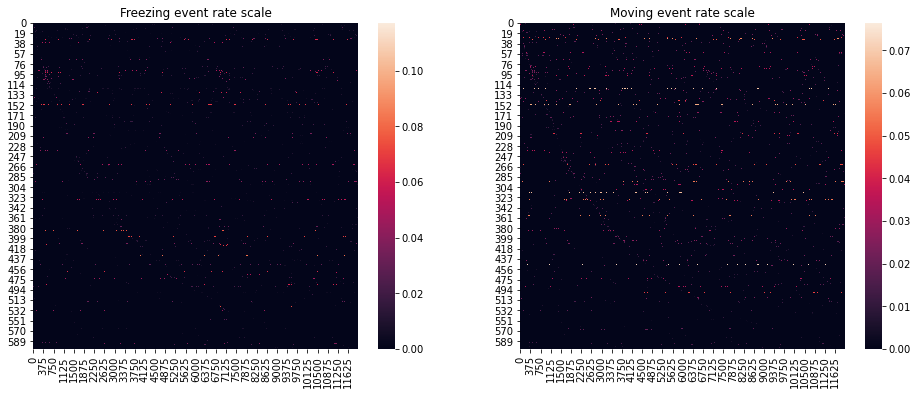

In [7]:
# Get event rates during freezing epochs (and moving epochs) - folded into functions freezing_analysis.freeze_event_rate() and .move_event_rate()!
event_rate_freezing = PF.PSAbool_align[:,freezingPSA].sum(axis=1)/(freezingPSA.sum())
event_rate_moving = PF.PSAbool_align[:,np.bitwise_not(freezingPSA)].sum(axis=1)/(np.bitwise_not(freezingPSA).sum())

# Now scale PSAbool by event rate during freezing! (and moving)
PSA_freeze_event_rate = (PF.PSAbool_align.swapaxes(0,1)*event_rate_freezing).swapaxes(0,1)
PSA_move_event_rate = (PF.PSAbool_align.swapaxes(0,1)*event_rate_moving).swapaxes(0,1)

fig, ax = plt.subplots(1,2)
fig.set_size_inches(16, 6)

for a, PSA, title_use in zip(ax, [PSA_freeze_event_rate, PSA_move_event_rate], ['Freezing event rate scale', 'Moving event rate scale']):
    sns.heatmap(data=PSA, ax=a)
    a.set_title(title_use)

<AxesSubplot:>

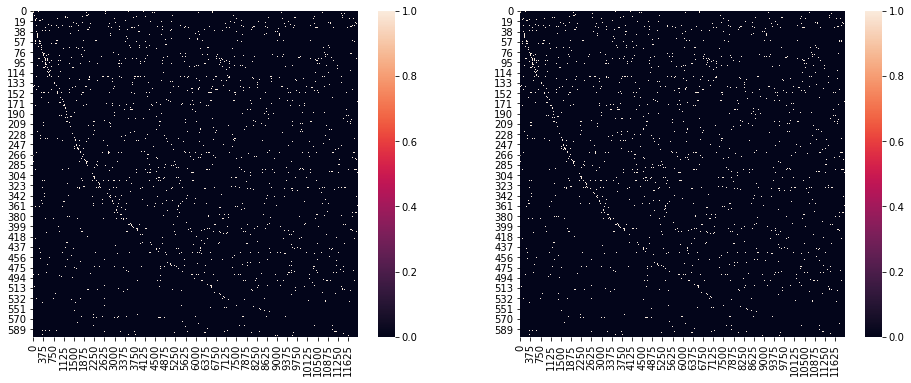

In [8]:
# Double check - adding things back together should recapitulate PSAbool - it does, more or less! 
# Make sure to plot side by side with the original!

fig, ax = plt.subplots(1,2)
fig.set_size_inches(16,6)
sns.heatmap(data=(PSA_freeze_event_rate + PSA_move_event_rate) > 0, ax=ax[0])
sns.heatmap(data=PF.PSAbool_align, ax=ax[1])

In [9]:
# Indeed, these are exactly the same arrays, so move forward
np.sum(PF.PSAbool_align - ((PSA_freeze_event_rate + PSA_move_event_rate) > 0), axis=1).sum()

0

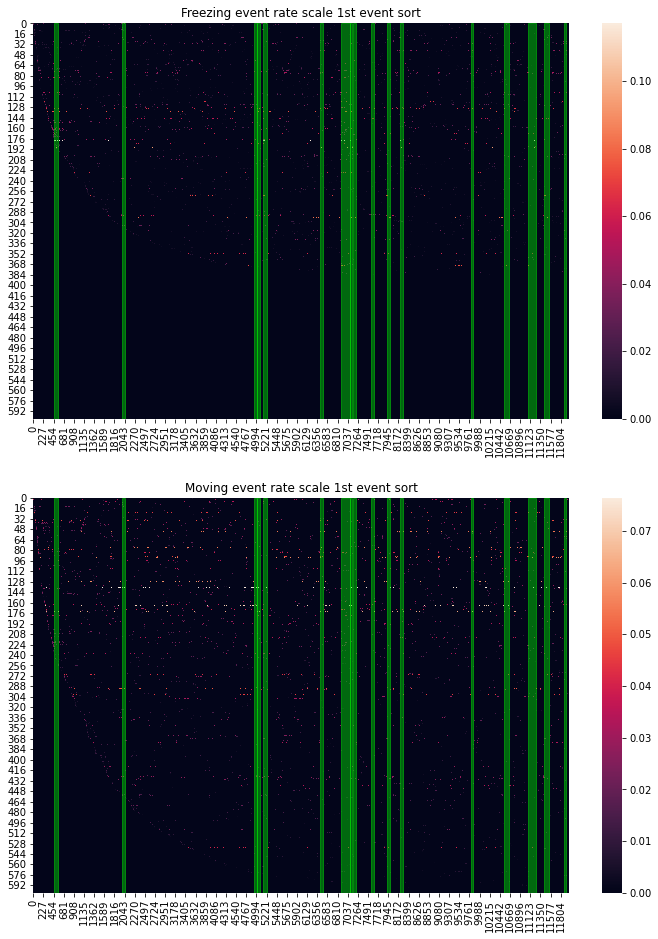

In [10]:
fig, ax = plt.subplots(2,1)
fig.set_size_inches(12, 16)
titles = ['Freezing event rate scale', 'Moving event rate scale']

for a, PSA, title_use in zip(ax, [PSA_freeze_event_rate, PSA_move_event_rate], titles ):
    sns.heatmap(data=helpers.sortPSA(PSA), ax=a)
    a.set_title(title_use + ' 1st event sort')
    
    for freeze_time in freezing_times:
        a.axvspan(freeze_time[0]*PF.sr_image, freeze_time[1]*PF.sr_image, color=[0, 1, 0, 0.4])

After all this the above looks kind of wonky, so try again with full plot and overlay freezing in green.

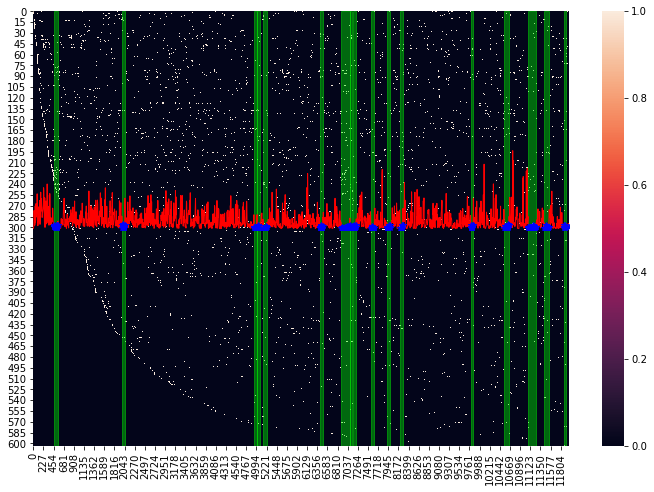

In [11]:
%matplotlib inline
SFvel = 4  # Factor to scale velocity by for overlay below

fig, ax = plt.subplots()
fig.set_size_inches([12,8])
sns.heatmap(data=helpers.sortPSA(PF.PSAbool_align), ax=ax)
nneurons = PF.PSAbool_align.shape[0]
ax.plot(video_t*PF.sr_image, velocity*-SFvel+nneurons/2, color='r', linewidth=1)
ax.plot(video_t[freezing]*PF.sr_image, velocity[freezing]*-SFvel+nneurons/2, 'b*')

for freeze_time in freezing_times:
    ax.axvspan(freeze_time[0]*PF.sr_image, freeze_time[1]*PF.sr_image, color=[0, 1, 0, 0.4])

Ok, now try sorting by event rate during moving/freezing!


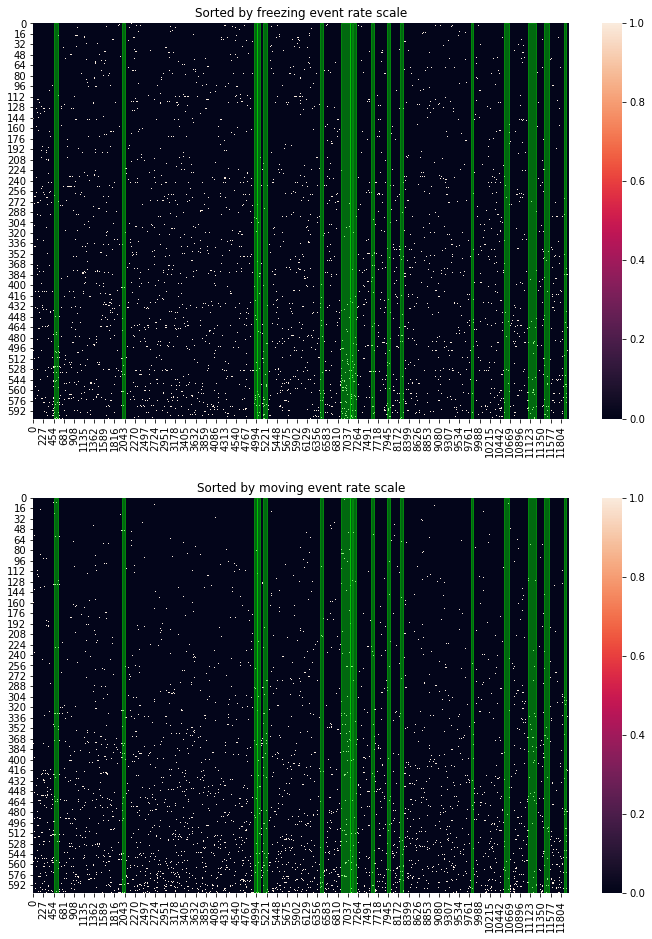

In [12]:
fig, ax = plt.subplots(2,1)
fig.set_size_inches(12, 16)
titles = ['Sorted by freezing event rate scale', 'Sorted by moving event rate scale']

for a, event_rate, title_use in zip(ax, [event_rate_freezing, event_rate_moving], titles ):
    sns.heatmap(data=helpers.sortPSA(PF.PSAbool_align, sort_by=event_rate), ax=a)
    a.set_title(title_use)
    
    # Overlay freezing in green?
    for freeze_time in freezing_times:
        a.axvspan(freeze_time[0]*PF.sr_image, freeze_time[1]*PF.sr_image, color=[0, 1, 0, 0.4])

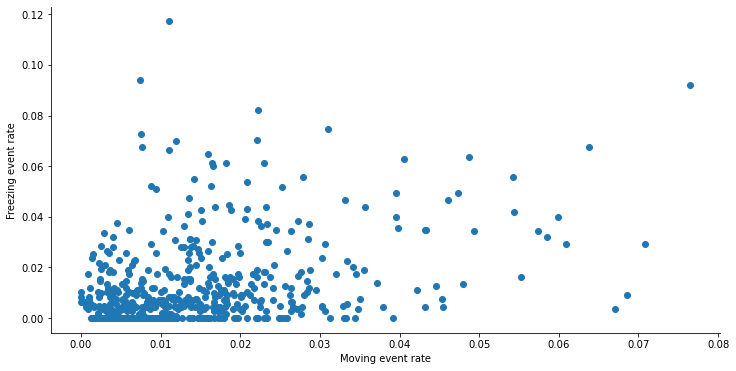

In [13]:
fig, ax = plt.subplots()
fig.set_size_inches((12,6))
ax.scatter(event_rate_moving, event_rate_freezing)
ax.set_xlabel('Moving event rate')
ax.set_ylabel('Freezing event rate')

sns.despine(ax=ax)

Let's look at the distribution of how cells get modulated by motion vs. freezing.

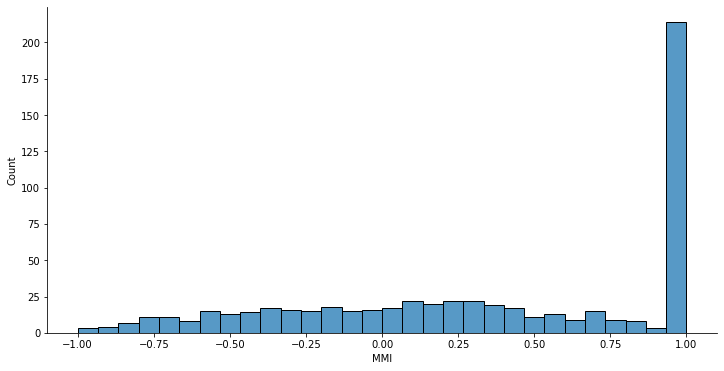

In [14]:
MMI = (event_rate_moving - event_rate_freezing)/(event_rate_moving + event_rate_freezing)
fig = plt.figure(figsize=(12,6))
sns.histplot(MMI, bins=30)
ax = plt.gca()
ax.set_xlabel('MMI')
sns.despine(ax=ax)

Ok, so for this initial session when the mouse is just going crazy running around there are a lot of "motion only" cells. Which is to be expected since there is very little freezing.

In [15]:
print('# pure freezing cells = ' + str((MMI == -1).sum()))
print('# pure motion cells = ' + str((MMI == 1).sum()))

# pure freezing cells = 3
# pure motion cells = 214


I folded a bunch of the code into a function to calculate MMI for each session quickly - double check it matches.

/Users/nkinsky/Documents/BU/Working/Eraser/Control Group/Marble7/20180319_2_fcbox: nbadpts = 2 max_in_a_row = 1


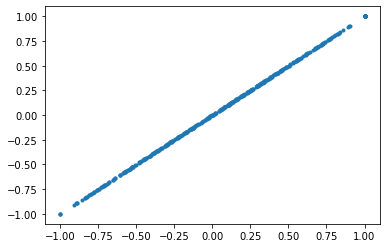

In [16]:
MMI2 = fa.motion_modulation_index(mouse, arena, day)
fig, ax = plt.subplots()
plt.plot(MMI, MMI2, '.')

Ok, looks good, so move onto tracking across days.  Start out by plotting for all sessions!

/Users/nkinsky/Documents/BU/Working/Eraser/Control Group/Marble7/20180319_1_openfield: nbadpts = 3 max_in_a_row = 1
/Users/nkinsky/Documents/BU/Working/Eraser/Control Group/Marble7/20180319_2_fcbox: nbadpts = 2 max_in_a_row = 1
/Users/nkinsky/Documents/BU/Working/Eraser/Control Group/Marble7/20180320_1_openfield: nbadpts = 0 max_in_a_row = 1
/Users/nkinsky/Documents/BU/Working/Eraser/Control Group/Marble7/20180320_2_fcbox: nbadpts = 0 max_in_a_row = 1
/Users/nkinsky/Documents/BU/Working/Eraser/Control Group/Marble7/20180321_3_openfield: nbadpts = 0 max_in_a_row = 1
/Users/nkinsky/Documents/BU/Working/Eraser/Control Group/Marble7/20180321_4_fcbox: nbadpts = 0 max_in_a_row = 1
/Users/nkinsky/Documents/BU/Working/Eraser/Control Group/Marble7/20180322_1_openfield: nbadpts = 8 max_in_a_row = 1
/Users/nkinsky/Documents/BU/Working/Eraser/Control Group/Marble7/20180322_2_fcbox: nbadpts = 0 max_in_a_row = 1
/Users/nkinsky/Documents/BU/Working/Eraser/Control Group/Marble7/20180323_1_openfield: n

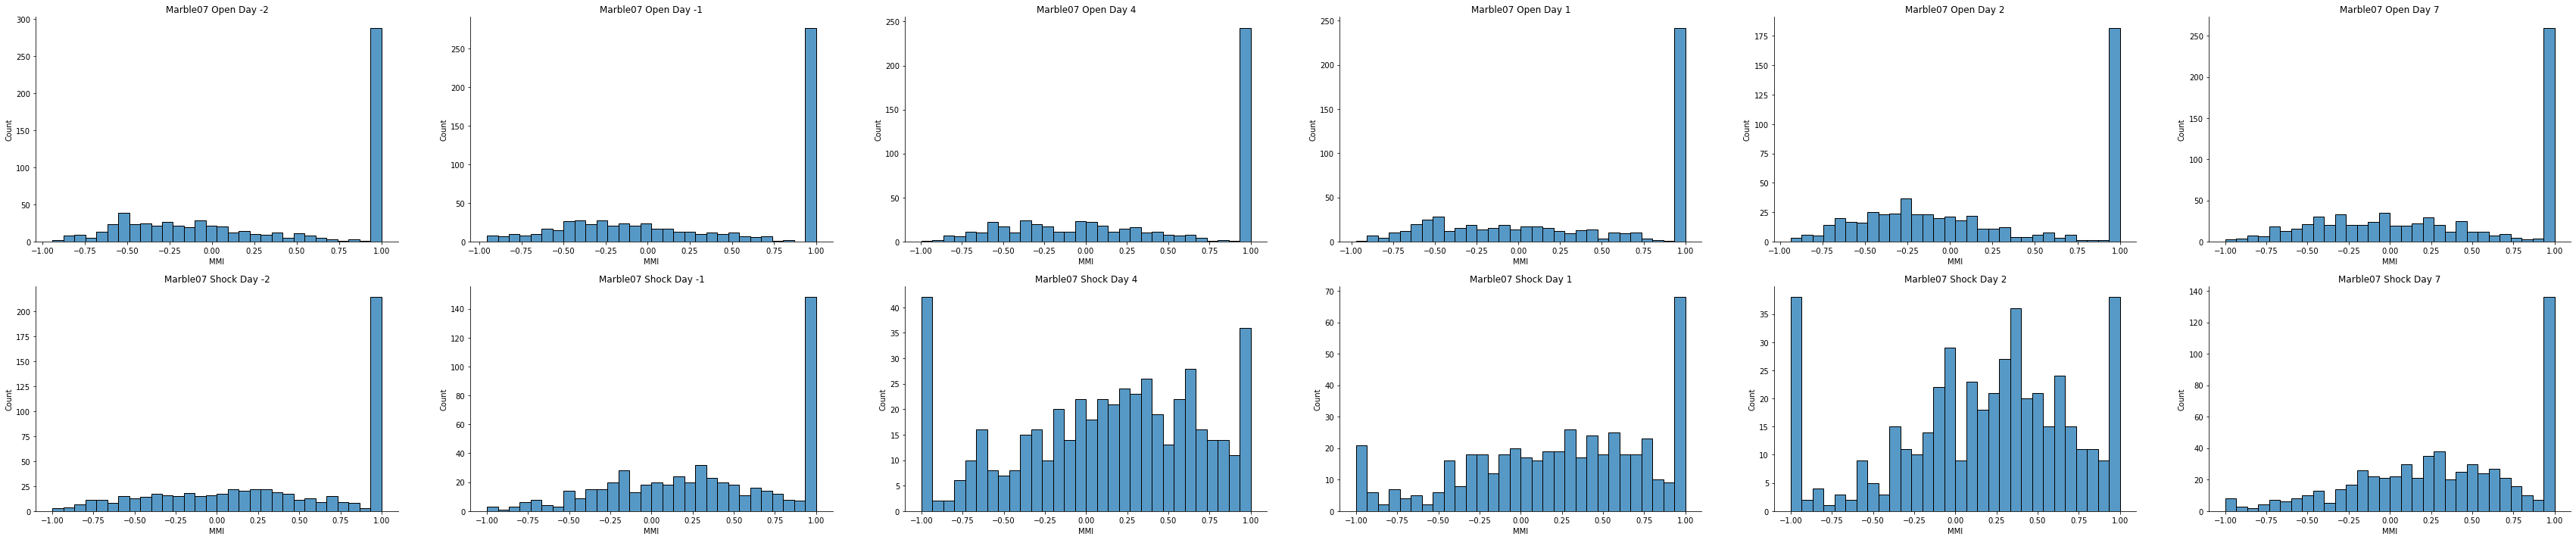

In [17]:
mouse = 'Marble07'
fig = plt.figure(figsize=(60, 12))
spec = gridspec.GridSpec(nrows=2, ncols=6, figure=fig)

for idd, day in enumerate([-2, -1, 4, 1, 2, 7]):

    # Set up axes for each day
    ax_open = fig.add_subplot(spec[0, idd])
    ax_shock = fig.add_subplot(spec[1, idd])
    
    # plot everything
    for ida, (ax, arena) in enumerate(zip([ax_open, ax_shock], ['Open', 'Shock'])):
        MMI = fa.motion_modulation_index(mouse, arena, day)
        sns.histplot(MMI, bins=30, ax=ax)
        ax.set_xlabel('MMI')
        ax.set_title(mouse + ' ' + arena + ' Day ' + str(day))
        sns.despine(ax=ax)
    

Step back and visualize PSAbool across days to see how freezing neurons track across days. This work is all taking place in freezing_analysis.plot_PSA_w_freezing().

Things to look at next:  

0) Plot PSAbool with velocity/freezing overlaid across ALL days in shock box for a learner and non-learner to a) make sure things continue to stay properly aligned and b) visualize any interesting effects I may have missed.  YES! Follow up with this for sure across days now that funciton is working!

1) Track freezing cells across days - maybe best to set up a motion modulation index "MMI" with -1 = only active during freezing and 1 = only active during motion?  Then track changes in MMI across days. AND compare to chance...(cell identity shuffle).

2) Ditto for freezing potentiated cells (1st transient during freezing epoch). 

3) Same as above for all these things but for cells active right BEFORE freezing (e.g. freezing predictive cells).